# Advanced Statistical Inference -- MCMC for Bayesian Logistic Regression


In this notebook, you will learn how to

- Implement the MH algorithm,
- Use it to compute classification probabilities.
- Understand how to run diagnostics on MCMC runs

# 1. Model and data

In this lab, you’re going to implement the Metropolis-Hasting algorithm described in the lecture for binary classification.

In [3]:
import functools
import warnings

import jax
import jax.numpy as jnp
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import scipy.linalg
import scipy.stats
from matplotlib import rc
from mpl_toolkits.mplot3d import Axes3D

warnings.filterwarnings("ignore")

colab = "google.colab" in str(get_ipython())
preamble = r"""\renewcommand{\familydefault}{\sfdefault}\usepackage{sansmath}
\usepackage{FiraSans}\sansmath\usepackage{amsmath}"""

rc("font", **{"family": "sans-serif", "sans-serif": "DejaVu Sans"})
rc("text", **{"usetex": False, "latex.preamble": preamble})
rc("figure", **{"dpi": 200})
rc(
    "axes",
    **{"spines.right": False, "spines.top": False, "xmargin": 0.0, "ymargin": 0.05}
)


def plot_data(X, y, ax):
    mask = y == 1
    config = dict(edgecolor="black", linewidth=1, zorder=10)
    ax.scatter(*X[mask].T, label="Class 1", facecolor="tab:blue", **config)
    ax.scatter(*X[~mask].T, label="Class 0", facecolor="tab:orange", **config)


def get_grid(xlim=(-3, 3), ylim=None, N=100):
    if ylim is None:
        ylim = xlim
    x_grid = np.linspace(*xlim, N)
    y_grid = np.linspace(*ylim, N)
    xx, yy = np.meshgrid(x_grid, y_grid)
    X_plot = np.vstack((xx.flatten(), yy.flatten())).T
    return xx, yy, X_plot

**Exercise:**
Load and plot the data

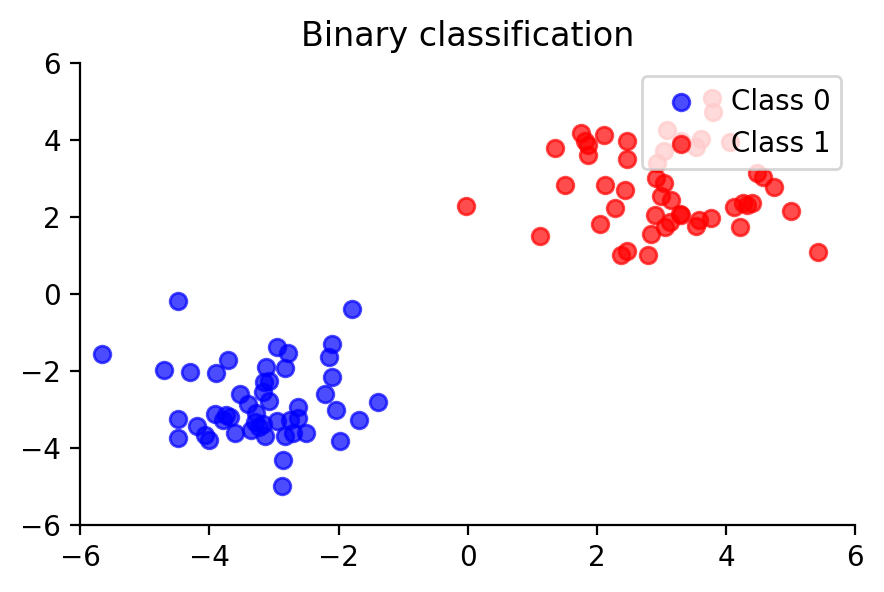

In [8]:
data = np.loadtxt("https://github.com/eurecom-ds/asi-labs/raw/refs/heads/master/lab_week2/binaryclass2.csv", delimiter=",")
X = data[..., :-1]
y = data[..., -1]

fig, ax = plt.subplots(figsize=[5, 3])
# @@ COMPLETE @@
class0 = X[y == 0]
class1 = X[y == 1]
ax.scatter(class0[:, 0], class0[:, 1], color='blue', label='Class 0', alpha=0.7)
ax.scatter(class1[:, 0], class1[:, 1], color='red', label='Class 1', alpha=0.7)

ax.set_title("Binary classification")
ax.legend(loc='upper right')
ax.set_xlim(-6, 6), ax.set_ylim(-6, 6)
plt.show()

For logistic regression (binary), we use the logistic (or sigmoid) function defined like $h(z) = (1+\exp(-z))^{-1}$.

**Exercise:**
Implement the logistic function and plot it.

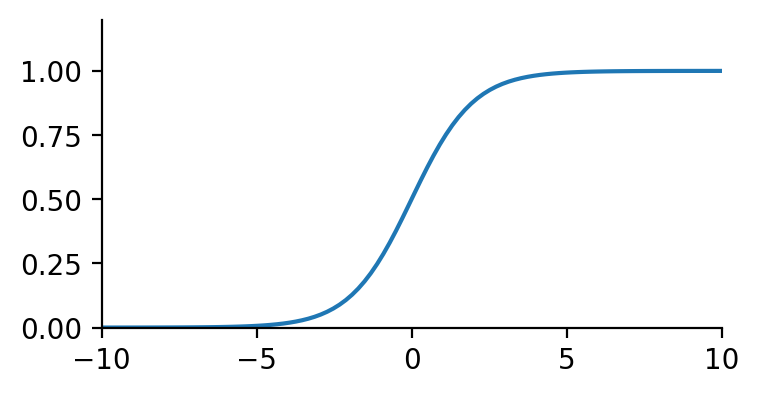

In [9]:
def logistic(z):
    # @@ COMPLETE @@
    out = (1 + np.exp(-z))**(-1)
    return out


z = np.linspace(-10, 10, 100)
fig, ax = plt.subplots(figsize=[4, 2])
ax.plot(z, logistic(z))
ax.set_ylim(0, 1.2)
plt.show()

The likelihood that we will use is the *Bernoulli likelihood*. Its density is defined as follows

$$
\log p({y}|{p}) = {y} \log({p}) + (1 - {y}) \log(1 - {p})
$$

where ${y}$ is the target class [0, 1] and ${p}$ is the predictive probability (i.e. the output of the logistic regression).

**Exercise:**
Complete the following class to compute the Bernoulli loglikelihood.

**Exercise:**
Complete also the code for computing the Gaussian logdensity with zero mean and diagonal covariance (check the previous labs).

In [10]:
def bernoulli_density(y, p):
    # @@ COMPLETE @@
    out = y*np.log(p)+(1-y)*np.log(1-p)
    return out


def gaussian_density(x, mean=0, var=1):
    # @@ COMPLETE @@
    out = (1/(np.sqrt(2*np.pi*var)))*np.exp(-(x-mean)**2/(2*var))
    return out

# 2. Random Walk with Metropolis-Hastings correction

Check the lecture notes for the full analysis of the sampler. Below you will find just a summary:

1. Produces a sequence of samples – $\boldsymbol{w}_1, \boldsymbol{w}_2, \dots, \boldsymbol{w}_s, \dots$
- Imagine we’ve just produced $\boldsymbol{w}_{s-1}$
- MH firsts proposes a possible $\boldsymbol{w}_s$ (call it $\boldsymbol{\tilde w}_s$) based on $\boldsymbol{w}_{s-1}$.
- MH then decides whether or not to accept wfs
    - If accepted, $\boldsymbol{w}_s \leftarrow \boldsymbol{\tilde w}_s$
    - If not, $\boldsymbol{w}_s \leftarrow \boldsymbol{w}_{s-1}$

We need to treat $\boldsymbol{\tilde w}_s$ as a random variable conditioned on $\boldsymbol{w}_{s-1}$. We can choose whatever we like but a simple solution is to use a Gaussian centered on  $\boldsymbol{w}_{s-1}$ with some covariance $\boldsymbol{\Sigma}_p$.

Regarding the acceptance, we need to compute the acceptance ratio. Check the lecture notes for the full derivation.
The first thing that we need to compute is the un-normalized logposterior (i.e. the sum of loglikelihood and prior):

$$
\log p(\boldsymbol{w}|\boldsymbol{X},\boldsymbol{y}) \propto \log p(\boldsymbol{y}|\boldsymbol{w}, \boldsymbol{X}) + \log p(\boldsymbol{w}) := g(\boldsymbol{w}; \boldsymbol{X}, \boldsymbol{y})
$$

**Exercise:**
Complete the class below with the code to compute the unnormalized logdensity $g(\boldsymbol{w}; \boldsymbol{X}, \boldsymbol{y})$.

In [11]:
def logposterior(w, X, y):

    z = X @ w
    p = 1 / (1 + np.exp(-z))  # sigmoid
    log_likelihood = bernoulli_density(y, p)  # already in log form

    # gaussian_density returns density, so we take log of it for the prior
    log_prior = np.sum(np.log(gaussian_density(w)))

    log_posterior = np.sum(log_likelihood) + log_prior
    return log_posterior

**Exercise:**
Now you can move to the actual random walsh with MH. Complete the `rw_mh_step()` function following the flowchart in the slides.


In [13]:
def rw_mh_step(w_prev, step_size):
    # @@ COMPLETE @@
    w_next = w_prev + np.random.normal(size=w_prev.shape) * step_size

    log_w_prev = logposterior(w_prev, X, y)
    log_w_next = logposterior(w_next, X, y)

    alpha = log_w_next - log_w_prev # Since we are using log, use subtraction instead of division

    u = np.random.rand()
    A = min(1, np.exp(alpha)) #np.exp is needed for alpha since alpha is computed with log, so we need to revert it

    if u <= A:
        w_next = w_next
    else:
        w_next = w_prev

    return w_next

Below, you have the run the sampling for a given number of iterations.

In [14]:
def run_sampling(w, n_samples, step_size=1):
    w = np.atleast_1d(w)
    samples = np.empty((n_samples, *w.shape))
    for i in range(n_samples):
        w = rw_mh_step(w, step_size)
        samples[i] = w
    return samples

**Exercise:**
Run the sampler for 10000 steps (you can fix the step size for the proposal to 0.5).

In [35]:
w_init = np.zeros(2)
# @@ COMPLETE @@
samples = run_sampling(w_init, 10000, 0.5)
print("Shape of samples:", samples.shape)

Shape of samples: (10000, 2)


**Exercise:**
Plot the samples and their distribution.

In [36]:
def plot_posterior(ax):
    xx, yy, X_plot = get_grid(xlim=(-1.5, 5.5), N=250)
    vals = np.zeros(len(X_plot))
    for i, w in enumerate(X_plot):
        vals[i] = np.exp(logposterior(w, X, y))
    levels = np.linspace(1e-5, max(vals), 10)
    patch = ax.contourf(
        xx, yy, vals.reshape(*xx.shape), cmap="cividis", alpha=0.6, levels=levels
    )
    ax.contour(xx, yy, vals.reshape(*xx.shape), cmap="cividis", levels=patch.levels[0:])

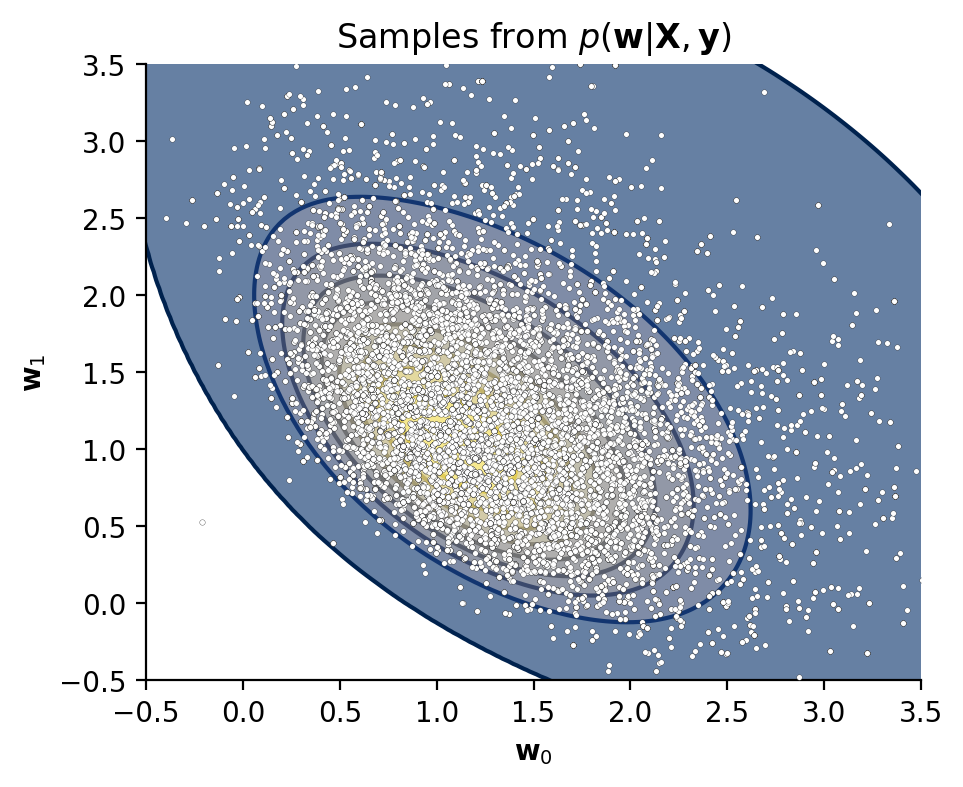

In [37]:
fig, ax = plt.subplots(figsize=[5, 4])
ax.scatter(
    *samples.T, s=4, edgecolor="black", linewidth=0.1, zorder=10, facecolor="white"
)
plot_posterior(ax)
ax.set_xlim(-0.5, 3.5), ax.set_ylim(-0.5, 3.5)
ax.set_xlabel(r"$\mathbf{w}_0$")
ax.set_ylabel(r"$\mathbf{w}_1$")
ax.set_title(r"Samples from $p(\mathbf{w}|\mathbf{X},\mathbf{y}) $")
plt.show()

Now, we can make predictions.
Remember that our motivation for being Bayesian was to be able to average predictions at $\boldsymbol{x}_\mathrm{new}$, for all possible $\boldsymbol{w}$.
This is possible by computing the following expectation:

$$
\boldsymbol{E}_{p(\boldsymbol{w}|\boldsymbol{X}, \boldsymbol{y}, \sigma_\mathrm{n})}h(\boldsymbol{w}^\top\boldsymbol{x}_\mathrm{new}) = \int h(\boldsymbol{w}^\top\boldsymbol{x}_\mathrm{new}) p(\boldsymbol{w}|\boldsymbol{X}, \boldsymbol{y}) \mathrm{d}\boldsymbol{w}
$$

**Exercise:**
Complete the next function to compute this expectation. And compute the probability $P (y_\mathrm{new} = 1 | \boldsymbol{x}_\mathrm{new}, \boldsymbol{X}, \boldsymbol{y})$ when $\boldsymbol{x}_\mathrm{new} = [2,-4]^\top$ .

Own NOTE: We have sampled from the logposterior over the weights. In classification, we average the classification from each sample.


In [52]:
def predict(Xt, samples):
    # @@ COMPLETE @@
    h = logistic(Xt @ samples.T) # Here we are taking into account all samples of w
    #Ref slides: doing logistic(Xt@samples.T) checks the probability for class 1. For class 0 you need
    # 1-logistic(Xt @ samples.T), however since we are doing binary classification, the probabilities of both classes will sum to 1.
    # Thus we just need to set a threshold instead.
    probs = np.mean(h, axis=1)
    return probs

In [57]:
predict([[2, -4]], samples)

array([0.27145007])

**Exercise:**
Now predict on a grid of points and plot the predictive probabilities (use the two helper function below).

In [54]:
def plot_decision_boundary(xx, yy, P, ax):
    P = P.reshape(*xx.shape)
    levels = [0, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 1]
    cs = ax.contour(xx, yy, P, levels, colors="k", linewidths=1.8, zorder=100)
    ax.clabel(cs, inline=1, fontsize=10)
    cs = ax.contourf(xx, yy, P, levels, cmap="Purples_r", alpha=0.5)

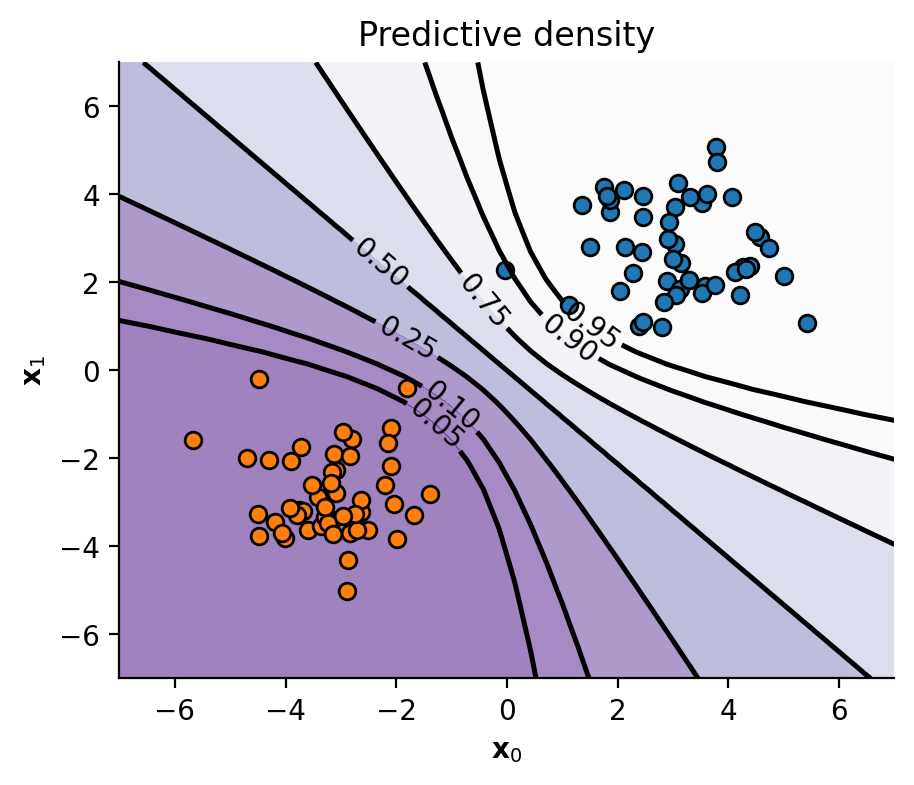

In [55]:
xx, yy, X_grid = get_grid((-7, 7), N=50)
ps = predict(X_grid, samples)

fig, ax = plt.subplots(figsize=[5, 4])
plot_decision_boundary(xx, yy, ps, ax=ax)
plot_data(X, y, ax=ax)

ax.set_xlabel(r"$\mathbf{x}_0$")
ax.set_ylabel(r"$\mathbf{x}_1$")
ax.set_title("Predictive density")
plt.show()

# 3. Assessing convergence of MCMC

Now that the MCMC sampler is done and working, we can move to some analysis.
If your algorithm is designed properly, the Markov chain will converge to the target distribution after *infinite* iterations.
We need to decide when is it wise to make inferences based on a finite Markov chain.
Assessing the convergence of your MCMC is essential if you want to:

- Base your conclusions on posterior distributions
- Report accurate parameter estimates & uncertainties
- Avoid fooling yourself
- Avoid devoting resources to follow-up an “inference” that isn’t supported by data
- Avoid writing an erratum to your homework

## 3.1 Burn-in

**Exercise:**
Sometimes choosing the initial point to start the MCMC is not easy. Choose some very wrong poins (say $[-4, -4]^\top$) and run the sampler for 10000 (set the step size to 0.1).
Plot the trajectory of the first 100s steps with a different color. What do you observe?

In [58]:
# @@ COMPLETE @@
w_init = [-4, -4]
samples = run_sampling(w_init, 10000, 0.1)

print("Shape of samples:", samples.shape)

Shape of samples: (10000, 2)


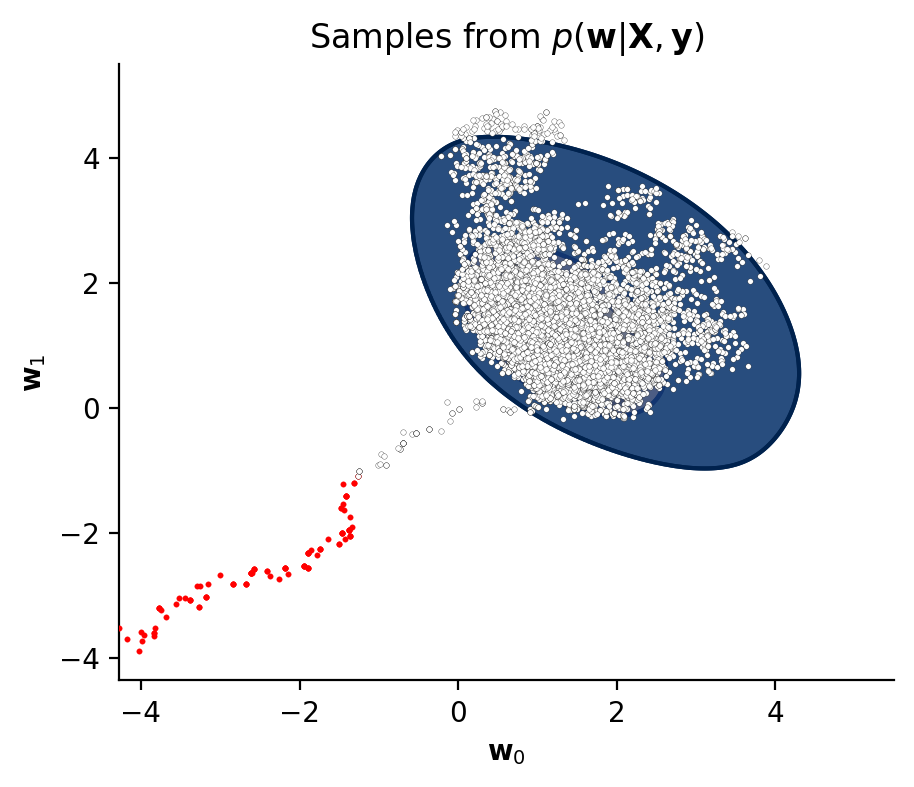

In [63]:
fig, ax = plt.subplots(figsize=[5, 4])
# @@ COMPLETE @@
ax.scatter(*samples[:100].T, s=4, edgecolor="red", linewidth=0.1, zorder=10, facecolor="red")
plot_posterior(ax)
ax.scatter(*samples[100:].T, s=4, edgecolor="black", linewidth=0.1, zorder=10, facecolor="white")
plot_posterior(ax)

ax.set_xlabel(r"$\mathbf{w}_0$")
ax.set_ylabel(r"$\mathbf{w}_1$")
ax.set_title(r"Samples from $p(\mathbf{w}|\mathbf{X},\mathbf{y}) $")
plt.show()

Own NOTE: We are using MCMC to sample from the posterior over the weights. We are starting the Markov-Chain at a random point, which may not be close to the posterior distribution. We dont want these samples to be included for the final estimate of the posterior, thus we remove them
Ref to the predictive density plot above, if the burn-in samples were included, the borders may have been somewhat distorted.
If we have a high dimensionality problem, the amount of burn-in samples may have been much higher.

This effect can be mitigated by using burn-in.
Burn-in is intended to give the Markov Chain time to reach its equilibrium distribution, particularly if it has started from a lousy starting point. To "burn in" a chain, you just discard the first $n$ samples before you start collecting points.

The idea is that a "bad" starting point may over-sample regions that are actually very low probability under the equilibrium distribution before it settles into the equilibrium distribution. If you throw those points away, then the points which should be unlikely will be suitably rare.

It clear that the burn-in is more of a hack/artform than a principled technique. In theory, you could just sample for a really long time or find some way to choose a decent starting point instead.

## 3.2 Trace plots

The trace plot shows the sampled values of a parameter over time (iterations). This plot helps you to judge how quickly the MCMC procedure converges in distribution—that is, how quickly it forgets its starting values.

**Exercise:**
For the two parameters of $\boldsymbol{w}$, plot their trace.

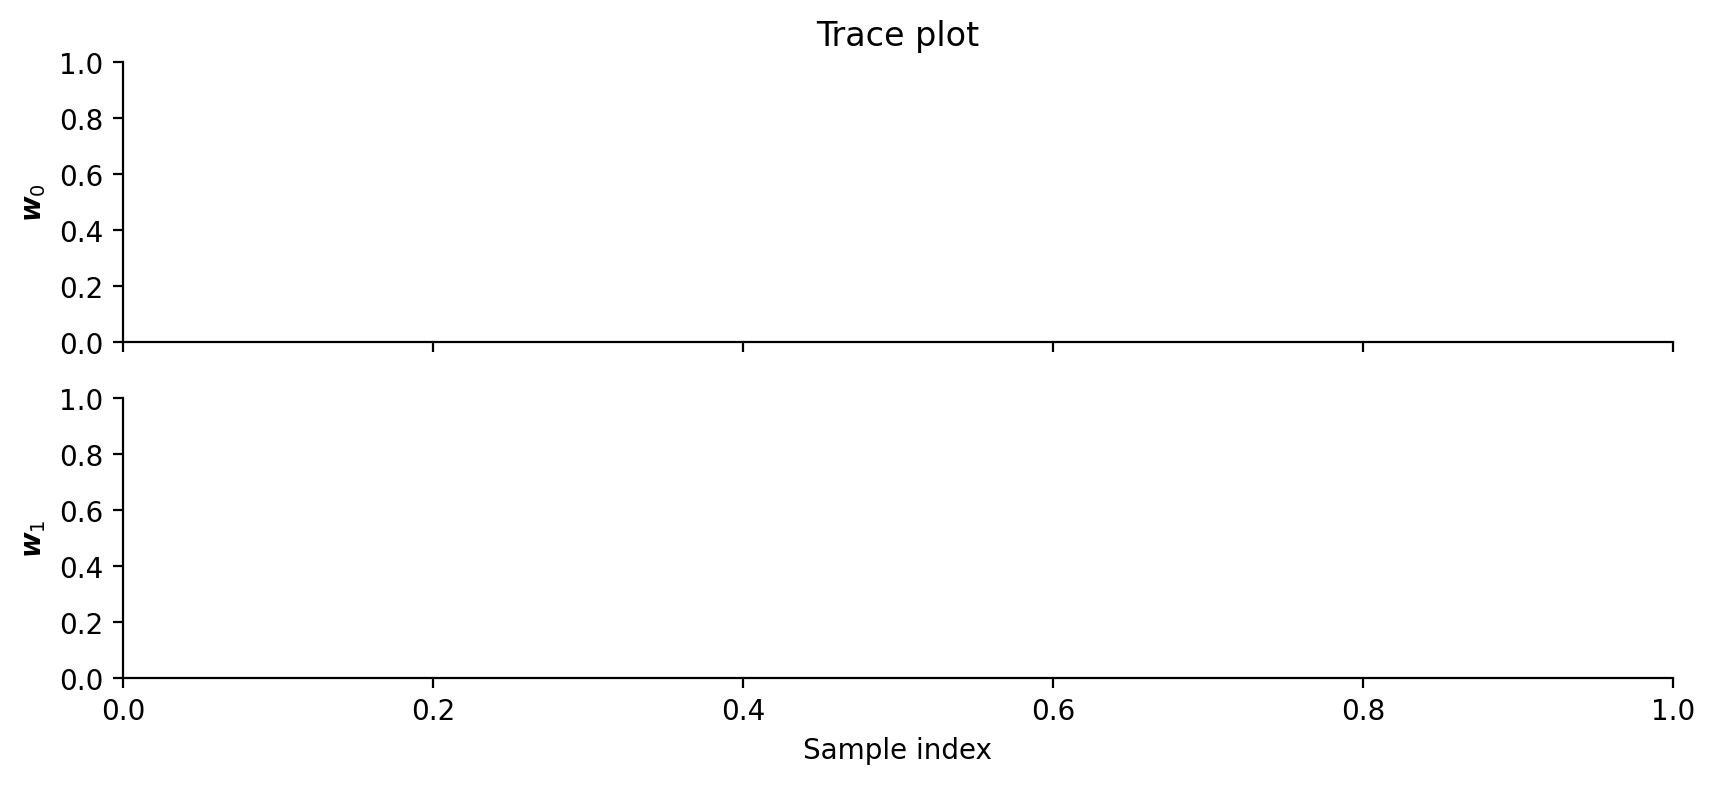

In [64]:
w_init = [0, 0]

fig, (ax0, ax1) = plt.subplots(2, 1, figsize=[10, 4], sharex=True)

# @@ COMPLETE @@
samples = run_sampling(w_init, 10000, 0.1)


ax0.set_ylabel(r"$\boldsymbol{w}_0$")
ax1.set_ylabel(r"$\boldsymbol{w}_1$")
ax0.set_title("Trace plot")
ax1.set_xlabel(r"Sample index")
plt.show()

**Exercise**: Change the step size, sample and plot the trace. Try 10, 1, 0.1 and 0.01. What behavior do you see? Comment the plots.

In [ ]:
# @@ COMPLETE @@


# @@ COMPLETE @@

## 3.2 Multiple chains and a more sophisticated diagnostics

In an attempt to assuage concerns of poor convergence, we typically run multiple independent chains to see if the
obtained distribution is similar across chains. We can also visually inspect the sample paths of the chains via trace plots
as well as study summary statistics such as the empirical autocorrelation function.

**Exercise:**
Complete the following function to run multiple chain.

In [ ]:
def run_multiple_chains(w_init, n_chains, n_samples, step_size=0.5):
    w_init = np.atleast_1d(w_init)
    samples = np.zeros((n_chains, n_samples, *w_init.shape))
    # @@ COMPLETE @@
    return samples

**Exercise:**
Sample now from multiple independent chains and plot the traces.

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=[10, 4], sharex=True)
# @@ COMPLETE @@
axs[0].set_ylabel(r"$\boldsymbol{w}_0$")
axs[1].set_ylabel(r"$\boldsymbol{w}_1$")
axs[0].set_title("Trace plot with multiple chains")
plt.show()

**Exercise**: Decrease the step size, run 4 chains and plot the traces. What do you see?

In [ ]:
# @@ COMPLETE @@
# @@ COMPLETE @@


Of the various convergence diagnostics, probably the most widely used is the **potential scale reduction factor** $\hat R$.
It is recommended as the primary convergence diagnostic in widely applied software
packages for MCMC sampling such as Stan (Carpenter et al., 2017), JAGS (Plummer, 2003), WinBUGS (Lunn et al.,
2000), OpenBUGS (Lunn et al., 2009), PyMC3 (Salvatier et al., 2016), and NIMBLE (de Valpine et al., 2017), which
together are estimated to have hundreds of thousand of users.
$\hat R$ is computed for each scalar quantity of interest, as the standard deviation of that quantity from all the chains included together, divided by the root mean square of the separate within-chain standard deviations. The idea is that if a set of simulations have not mixed well, the variance
of all the chains mixed together should be higher than the variance of individual chains


At convergence, the chains will have mixed, so that the distribution of the simulations
between and within chains will be identical, and the ratio $\hat R$ should equal 1. If $\hat R$
is greater than 1, this implies that the chains have not fully mixed and that further simulation might increase the precision of inferences. In practice we typically go until $\hat R$ is less than 1.1/1.05 for all parameters.

In [ ]:
def compute_rhat(samples):
    """Compute the rhat statistics from samples. Samples needs to be a tensor
    with dimensions [num_of_chain, num_of_samples, num_of_variables]."""

    def _rhat_base(ary):
        """Compute the rhat for a 2d array."""
        _, num_samples = ary.shape

        # Calculate chain mean
        chain_mean = np.mean(ary, axis=1)
        # Calculate chain variance
        chain_var = np.var(ary, axis=1, ddof=1)
        # Calculate between-chain variance
        between_chain_variance = num_samples * np.var(chain_mean, axis=None, ddof=1)
        # Calculate within-chain variance
        within_chain_variance = np.mean(chain_var)
        # Estimate of marginal posterior variance
        rhat_value = np.sqrt(
            (between_chain_variance / within_chain_variance + num_samples - 1)
            / (num_samples)
        )
        return rhat_value

    def _split_chains(ary):
        """Split and stack chains."""
        _, n_draw = ary.shape
        half = n_draw // 2
        return np.vstack((ary[:half], ary[-half:]))

    samples = np.atleast_3d(samples)
    return np.asarray(
        [_rhat_base(_split_chains(samples[..., i])) for i in range(samples.shape[-1])]
    )

**Exercise:**
Using the function provided above, compute the $\hat R$-statistics for $\boldsymbol{w}$ with the following parameters:

- num_of_chain = 4
- num_of_samples = [100, 1000, 10000]
- step size = [1, 0.1, 0.01]

**Question:**
Comment the results. For which configurations $\hat R$-statistics suggests convergence has not been achieved?

In [ ]:
# @@ COMPLETE @@
print("Rhat:", r_hat)

**Exercise:**
The $\hat R$-statistics can also be plotted as a function of iteration. Complete the next code cell to visualize its behaviour.
Try also with step size = [0.5, 0.1, 0.01].

In [ ]:
steps = np.logspace(1, 5, 10).astype(int)
rhats = np.vstack([compute_rhat(samples[..., :i, :]) for i in steps])
fig, ax = plt.subplots(figsize=[8, 3])
ax.plot(steps, rhats, "o-")
ax.fill_between(steps, 0.9, 1.05, color="xkcd:leaf green", alpha=0.5, lw=0)
ax.fill_between(steps, 1.05, 1.15, color="xkcd:pumpkin orange", alpha=0.5, lw=0)
ax.set_title(r"$\hat R$ vs iterations")

# ax.set_ylim(0.9, 2)
ax.legend([r"$\boldsymbol{w}_0$", r"$\boldsymbol{w}_1$"])
ax.semilogx()

plt.show()